### Import Dependencies

In [293]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt

### Formulas

In [294]:
# The purpose of this formula is evaluate how often a particular team wins when they have the statistical advantage
# This percentage is used later to determine how much the algorithm can weigh the stats on a mathematically "better" team
# Outline for how it works:
# 1) User enters the WEEKLY dataframe they want to evaluate, and the TEAM they want the percentage for
# 2) A "base_df" is created from the weekly dataframe that only includes games played by the identified team
# 3) From the base_df, a list of the team's opponents is stored
# 4) The code loops through each opponent from the list in (3)
# 5) The TEAM is compared against each OPPONENT, and they are labelled the "winner" and "loser" based on the Results column
# 6) The numerical stats are compared in a simple > or < evaluation. Greater Offensive stats get a point, and lesser
#    defensive stats get a point.
# 7) Categorical stats, like QB and coaching staff, are compared based on the overall record of that person. That record
#    is evaluated from the allteam dataframe, regardless of team, opponent, year, or week. 
# 8) At the end of the loop, if the winning team has more of the statistical advantages, then that counter increases by one
# 9) After all opponents have been looped through, the formula calculates the % of times the winner had more advantages

def majperc(df, base):

    ##### Set evaluation formulas ######
    
    # Determines which categorical value has a higher win record and assigns a point to that team
    def cat_greater_point(column='', base='none'):
        win_value = win_row[column].sum()
        loss_value = loss_row[column].sum()

        if base == 'none':
            win_df = allteam_df[allteam_df[column] == win_value]
            loss_df = allteam_df[allteam_df[column] == loss_value]
        else:
            win_df = allteam_df[(allteam_df[column] == win_value) & (allteam_df['Base_Team'] == base)]
            loss_df = allteam_df[(allteam_df[column] == loss_value) & (allteam_df['Base_Team'] == base)]

        if len(win_df['Results']) == 0:
            if len(loss_df['Results']) == 0:
                base_count = 0
                base_sub = 0
            else:
                base_count = 0
                base_sub = 1
        elif len(loss_df['Results']) == 0:
            base_count = 1
            base_sub = 1
        else:
            win_rate = win_df['Results'].sum()/len(win_df['Results'])
            loss_rate = loss_df['Results'].sum()/len(loss_df['Results'])
            if win_rate > loss_rate:
                base_count = 1
            else:
                base_count = 0  
            base_sub = 1

        return base_count, base_sub
    
    # Determines which numerical value is greater and assigns a point to that team
    def num_greater_point(column=''):
        win_base = win_row[column].sum()
        loss_base = loss_row[column].sum()

        if win_base > loss_base:
            base_count = 1
        else:
            base_count = 0  
        base_sub = 1

        return base_count, base_sub
    
    #Determines which numerical value is lesser and assigns a point to that team
    def num_lesser_point(column=''):
        win_base = win_row[column].sum()
        loss_base = loss_row[column].sum()

        if win_base < loss_base:
            base_count = 1
        else:
            base_count = 0  
        base_sub = 1

        return base_count, base_sub
    
    #################################
    
    base_df = df[df['Base_Team'] == base]
    base_opps = base_df['Opp']
    base_total = 0
    base_maj = 0
    base_half = 0
    
    for opp in base_opps:

        teams = [base, opp]
        game_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams))]
        win_row = game_df.loc[(game_df['Results'] == 1)]
        loss_row = game_df.loc[(game_df['Results'] == 0)]

        winner = win_row['Base_Team'].sum()
        loser = loss_row['Base_Team'].sum()

        # Count Advantages
        
        HCbase_count, HCbase_sub = cat_greater_point(column='Head_Coach')
        OCbase_count, OCbase_sub = cat_greater_point(column='OC')
        DCbase_count, DCbase_sub = cat_greater_point(column='DC')
        QBbase_count, QBbase_sub = cat_greater_point(column='QB')
        
        DAYbase_count, DAYbase_sub = cat_greater_point(base=base, column='Day')
        HOMEbase_count, HOMEbase_sub = cat_greater_point(base=base, column='Home')
        ABbase_count, ABbase_sub = cat_greater_point(base=base, column='After_Bye')
                
        WTbase_count, WTbase_sub = num_greater_point(column='Wins Tally')
        PFbase_count, PFbase_sub = num_greater_point(column='PF Tally')
        OTYbase_count, OTYbase_sub = num_greater_point(column='OTotYd Tally')
        OPYbase_count, OPYbase_sub = num_greater_point(column='OPassY Tally')
        ORYbase_count, ORYbase_sub = num_greater_point(column='ORushY Tally')
        TOWbase_count, TOWbase_sub = num_greater_point(column='TO_won Tally')
        
        PAbase_count, PAbase_sub = num_lesser_point(column='PA Tally')
        DTYbase_count, DTYbase_sub = num_lesser_point(column='DTotYd Tally')
        DPYbase_count, DPYbase_sub = num_lesser_point(column='DPassY Tally')
        DRYbase_count, DRYbase_sub = num_lesser_point(column='DRushY Tally')
        TOLbase_count, TOLbase_sub = num_lesser_point(column='TO_lost Tally')

        count_list = [HCbase_count, OCbase_count, DCbase_count, QBbase_count, DAYbase_count, HOMEbase_count, ABbase_count, 
                      WTbase_count, PFbase_count, OTYbase_count, OPYbase_count, ORYbase_count, TOWbase_count, PAbase_count, 
                      DTYbase_count, DPYbase_count, DRYbase_count, TOLbase_count]
        
        sub_list = [HCbase_sub, OCbase_sub, DCbase_sub, QBbase_sub, DAYbase_sub, HOMEbase_sub, ABbase_sub, WTbase_sub, 
                    PFbase_sub, OTYbase_sub, OPYbase_sub, ORYbase_sub, TOWbase_sub, PAbase_sub, DTYbase_sub, DPYbase_sub, 
                    DRYbase_sub, TOLbase_sub]
        
        count = sum(count_list)
        sub = sum(sub_list)
        
        # Summation Calcs
        if count > sub/2:
            base_maj = base_maj + 1
            base_total = base_total + 1
        else:
            base_total = base_total + 1

    base_majperc = (base_maj/base_total) * 100
        
    return base_majperc

In [295]:
# Compares how well each team performs in the specified week and predicts a winner based on those precentages

def weekly_win_rate(weekly_df, team, opponent):
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    # Weekly win rate for each team
    base_week_rate = base_df['Results'].sum()/len(base_df['Results'])
    opp_week_rate = opp_df['Results'].sum()/len(opp_df['Results'])
    
    if base_week_rate > opp_week_rate:
        weekrate_winner = team
        weekrate_perc = (base_week_rate/(base_week_rate + opp_week_rate)) * 100
    else:
        weekrate_winner = opponent
        weekrate_perc = (opp_week_rate/(base_week_rate + opp_week_rate)) * 100
    
    return weekrate_winner, weekrate_perc

In [296]:
# Compares how these teams have performed against each other in the past and predicts a winner based on those results

def priors_win_rate(team, opponent):
    priors_df = allteam_df.loc[(allteam_df['Base_Team'] == team) & (allteam_df['Opp'] == opponent)]
    if len(priors_df['Results']) == 0:
        priorrate_winner = 'None'
        priorrate_perc = 0
    else:
        base_priors_rate = priors_df['Results'].sum()/len(priors_df['Results'])
        opp_priors_rate = (len(priors_df['Results']) - priors_df['Results'].sum())/len(priors_df['Results'])
        if base_priors_rate > opp_priors_rate:
            priorrate_winner = team
            priorrate_perc = (base_priors_rate/(base_priors_rate + opp_priors_rate)) * 100
            
        elif base_priors_rate == opp_priors_rate:
            priorrate_winner = 'None'
            priorrate_perc = 50
        else:
            priorrate_winner = opponent
            priorrate_perc = (opp_priors_rate/(base_priors_rate + opp_priors_rate)) * 100
            
    return priorrate_winner, priorrate_perc

In [297]:
# Advantage tally for each team in the upcoming matchup

def adv_win_rate_even(weekly_df, team, opponent):
    
    ######### Set Evaluation Formulas #########
    def base_opp_greater_point_cat(column='', team='none', opponent='none', weight=1):
        base_v = base_adv_row[column].sum()
        opp_v = opp_adv_row[column].sum()
        if team == 'none':
            base_v_df = allteam_df[allteam_df[column] == base_v]
            opp_v_df = allteam_df[allteam_df[column] == opp_v]
        else:
            base_v_df = allteam_df[(allteam_df[column] == base_v) & (allteam_df['Base_Team'] == team)]
            opp_v_df = allteam_df[(allteam_df[column] == opp_v) & (allteam_df['Base_Team'] == opponent)]

        if len(base_v_df['Results']) == 0:
            if len(opp_v_df['Results']) == 0:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
            else:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
        elif len(opp_v_df['Results']) == 0:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        else:
            base_v_rate = base_v_df['Results'].sum()/len(base_v_df['Results'])
            opp_v_rate = opp_v_df['Results'].sum()/len(opp_v_df['Results'])
            if base_v_rate > opp_v_rate:
                base_adv_count = weight
                opp_adv_count = 0
                adv_sub = weight
            elif base_v_rate < opp_v_rate:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
            else:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
                
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_greater_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base > tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base < tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_lesser_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base < tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base > tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    ##################################################
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    teams = [team, opponent]
    adv_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams)) & (df['Year'] == 2020)]
    
    base_adv_row = adv_df.loc[df['Base_Team'] == team]
    opp_adv_row = adv_df.loc[df['Base_Team'] == opponent]
    
    ## Assign Advantages
    HCbase_adv_count, HCopp_adv_count, HCadv_sub = base_opp_greater_point_cat(column='Head_Coach')
    OCbase_adv_count, OCopp_adv_count, OCadv_sub = base_opp_greater_point_cat(column='OC')
    DCbase_adv_count, DCopp_adv_count, DCadv_sub = base_opp_greater_point_cat(column='DC')
    QBbase_adv_count, QBopp_adv_count, QBadv_sub = base_opp_greater_point_cat(column='QB')
    DAYbase_adv_count, DAYopp_adv_count, DAYadv_sub = base_opp_greater_point_cat(column='Day', team=team, opponent=opponent)
    HOMEbase_adv_count, HOMEopp_adv_count, HOMEadv_sub = base_opp_greater_point_cat(column='Home', team=team, opponent=opponent)
    ABbase_adv_count, ABopp_adv_count, ABadv_sub = base_opp_greater_point_cat(column='After_Bye', team=team, opponent=opponent)

    WTbase_adv_count, WTopp_adv_count, WTadv_sub = base_opp_greater_point_num(column='Wins Tally')
    PFbase_adv_count, PFopp_adv_count, PFadv_sub = base_opp_greater_point_num(column='PF Tally')
    OTYbase_adv_count, OTYopp_adv_count, OTYadv_sub = base_opp_greater_point_num(column='OTotYd Tally')
    OPYbase_adv_count, OPYopp_adv_count, OPYadv_sub = base_opp_greater_point_num(column='OPassY Tally')
    ORYbase_adv_count, ORYopp_adv_count, ORYadv_sub = base_opp_greater_point_num(column='ORushY Tally')
    TOWbase_adv_count, TOWopp_adv_count, TOWadv_sub = base_opp_greater_point_num(column='TO_won Tally')

    PAbase_adv_count, PAopp_adv_count, PAadv_sub = base_opp_lesser_point_num(column='PA Tally')
    DTYbase_adv_count, DTYopp_adv_count, DTYadv_sub = base_opp_lesser_point_num(column='DTotYd Tally')
    DPYbase_adv_count, DPYopp_adv_count, DPYadv_sub = base_opp_lesser_point_num(column='DPassY Tally')
    DRYbase_adv_count, DRYopp_adv_count, DRYadv_sub = base_opp_lesser_point_num(column='DRushY Tally')
    TOLbase_adv_count, TOLopp_adv_count, TOLadv_sub = base_opp_lesser_point_num(column='TO_lost Tally')

    ## Tally Advantage
    
    base_adv_count_list = [HCbase_adv_count, OCbase_adv_count, DCbase_adv_count, QBbase_adv_count, DAYbase_adv_count, 
                          HOMEbase_adv_count, ABbase_adv_count, WTbase_adv_count, PFbase_adv_count, OTYbase_adv_count, 
                          OPYbase_adv_count, ORYbase_adv_count, TOWbase_adv_count, PAbase_adv_count, DTYbase_adv_count, 
                          DPYbase_adv_count, DRYbase_adv_count, TOLbase_adv_count]
    
    opp_adv_count_list = [HCopp_adv_count, OCopp_adv_count, DCopp_adv_count, QBopp_adv_count, DAYopp_adv_count, 
                         HOMEopp_adv_count, ABopp_adv_count, WTopp_adv_count, PFopp_adv_count, OTYopp_adv_count, 
                         OPYopp_adv_count, ORYopp_adv_count, TOWopp_adv_count, PAopp_adv_count, DTYopp_adv_count, 
                         DPYopp_adv_count, DRYopp_adv_count, TOLopp_adv_count]

    adv_sub_list = [HCadv_sub, OCadv_sub, DCadv_sub, QBadv_sub, DAYadv_sub, 
                    HOMEadv_sub, ABadv_sub, WTadv_sub, PFadv_sub, 
                    OTYadv_sub, OPYadv_sub, ORYadv_sub, TOWadv_sub, 
                    PAadv_sub, DTYadv_sub, DPYadv_sub, DRYadv_sub, TOLadv_sub]
    
    base_adv_count = sum(base_adv_count_list)
    opp_adv_count = sum(opp_adv_count_list)
    adv_sub = sum(adv_sub_list)
    
    return base_adv_count, opp_adv_count, adv_sub

In [353]:
# Advantage tally for each team in the upcoming matchup

def adv_win_rate_off(weekly_df, team, opponent):
    
    ######### Set Evaluation Formulas #########
    def base_opp_greater_point_cat(column='', team='none', opponent='none', weight=1):
        base_v = base_adv_row[column].sum()
        opp_v = opp_adv_row[column].sum()
        if team == 'none':
            base_v_df = allteam_df[allteam_df[column] == base_v]
            opp_v_df = allteam_df[allteam_df[column] == opp_v]
        else:
            base_v_df = allteam_df[(allteam_df[column] == base_v) & (allteam_df['Base_Team'] == team)]
            opp_v_df = allteam_df[(allteam_df[column] == opp_v) & (allteam_df['Base_Team'] == opponent)]

        if len(base_v_df['Results']) == 0:
            if len(opp_v_df['Results']) == 0:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
            else:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
        elif len(opp_v_df['Results']) == 0:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        else:
            base_v_rate = base_v_df['Results'].sum()/len(base_v_df['Results'])
            opp_v_rate = opp_v_df['Results'].sum()/len(opp_v_df['Results'])
            if base_v_rate > opp_v_rate:
                base_adv_count = weight
                opp_adv_count = 0
                adv_sub = weight
            elif base_v_rate < opp_v_rate:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
            else:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
                
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_greater_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base > tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base < tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_lesser_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base < tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base > tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    ##################################################
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    teams = [team, opponent]
    adv_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams)) & (df['Year'] == 2020)]
    
    base_adv_row = adv_df.loc[df['Base_Team'] == team]
    opp_adv_row = adv_df.loc[df['Base_Team'] == opponent]
    
    ## Assign Advantages
    HCbase_adv_count, HCopp_adv_count, HCadv_sub = base_opp_greater_point_cat(column='Head_Coach')
    OCbase_adv_count, OCopp_adv_count, OCadv_sub = base_opp_greater_point_cat(column='OC')
    DCbase_adv_count, DCopp_adv_count, DCadv_sub = base_opp_greater_point_cat(column='DC')
    QBbase_adv_count, QBopp_adv_count, QBadv_sub = base_opp_greater_point_cat(column='QB')
    DAYbase_adv_count, DAYopp_adv_count, DAYadv_sub = base_opp_greater_point_cat(column='Day', team=team, opponent=opponent)
    HOMEbase_adv_count, HOMEopp_adv_count, HOMEadv_sub = base_opp_greater_point_cat(column='Home', team=team, opponent=opponent)
    ABbase_adv_count, ABopp_adv_count, ABadv_sub = base_opp_greater_point_cat(column='After_Bye', team=team, opponent=opponent)

    WTbase_adv_count, WTopp_adv_count, WTadv_sub = base_opp_greater_point_num(column='Wins Tally')
    PFbase_adv_count, PFopp_adv_count, PFadv_sub = base_opp_greater_point_num(column='PF Tally', weight=3)
    OTYbase_adv_count, OTYopp_adv_count, OTYadv_sub = base_opp_greater_point_num(column='OTotYd Tally', weight=3)
    OPYbase_adv_count, OPYopp_adv_count, OPYadv_sub = base_opp_greater_point_num(column='OPassY Tally', weight=3)
    ORYbase_adv_count, ORYopp_adv_count, ORYadv_sub = base_opp_greater_point_num(column='ORushY Tally', weight=3)
    TOWbase_adv_count, TOWopp_adv_count, TOWadv_sub = base_opp_greater_point_num(column='TO_won Tally', weight=3)

    PAbase_adv_count, PAopp_adv_count, PAadv_sub = base_opp_lesser_point_num(column='PA Tally')
    DTYbase_adv_count, DTYopp_adv_count, DTYadv_sub = base_opp_lesser_point_num(column='DTotYd Tally')
    DPYbase_adv_count, DPYopp_adv_count, DPYadv_sub = base_opp_lesser_point_num(column='DPassY Tally')
    DRYbase_adv_count, DRYopp_adv_count, DRYadv_sub = base_opp_lesser_point_num(column='DRushY Tally')
    TOLbase_adv_count, TOLopp_adv_count, TOLadv_sub = base_opp_lesser_point_num(column='TO_lost Tally')

    ## Tally Advantage
    
    base_adv_count_list = [HCbase_adv_count, OCbase_adv_count, DCbase_adv_count, QBbase_adv_count, DAYbase_adv_count, 
                          HOMEbase_adv_count, ABbase_adv_count, WTbase_adv_count, PFbase_adv_count, OTYbase_adv_count, 
                          OPYbase_adv_count, ORYbase_adv_count, TOWbase_adv_count, PAbase_adv_count, DTYbase_adv_count, 
                          DPYbase_adv_count, DRYbase_adv_count, TOLbase_adv_count]
    
    opp_adv_count_list = [HCopp_adv_count, OCopp_adv_count, DCopp_adv_count, QBopp_adv_count, DAYopp_adv_count, 
                         HOMEopp_adv_count, ABopp_adv_count, WTopp_adv_count, PFopp_adv_count, OTYopp_adv_count, 
                         OPYopp_adv_count, ORYopp_adv_count, TOWopp_adv_count, PAopp_adv_count, DTYopp_adv_count, 
                         DPYopp_adv_count, DRYopp_adv_count, TOLopp_adv_count]

    adv_sub_list = [HCadv_sub, OCadv_sub, DCadv_sub, QBadv_sub, DAYadv_sub, 
                    HOMEadv_sub, ABadv_sub, WTadv_sub, PFadv_sub, 
                    OTYadv_sub, OPYadv_sub, ORYadv_sub, TOWadv_sub, 
                    PAadv_sub, DTYadv_sub, DPYadv_sub, DRYadv_sub, TOLadv_sub]
    
    base_adv_count = sum(base_adv_count_list)
    opp_adv_count = sum(opp_adv_count_list)
    adv_sub = sum(adv_sub_list)
    
    return base_adv_count, opp_adv_count, adv_sub

In [354]:
# Advantage tally for each team in the upcoming matchup

def adv_win_rate_def(weekly_df, team, opponent):
    
    ######### Set Evaluation Formulas #########
    def base_opp_greater_point_cat(column='', team='none', opponent='none', weight=1):
        base_v = base_adv_row[column].sum()
        opp_v = opp_adv_row[column].sum()
        if team == 'none':
            base_v_df = allteam_df[allteam_df[column] == base_v]
            opp_v_df = allteam_df[allteam_df[column] == opp_v]
        else:
            base_v_df = allteam_df[(allteam_df[column] == base_v) & (allteam_df['Base_Team'] == team)]
            opp_v_df = allteam_df[(allteam_df[column] == opp_v) & (allteam_df['Base_Team'] == opponent)]

        if len(base_v_df['Results']) == 0:
            if len(opp_v_df['Results']) == 0:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
            else:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
        elif len(opp_v_df['Results']) == 0:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        else:
            base_v_rate = base_v_df['Results'].sum()/len(base_v_df['Results'])
            opp_v_rate = opp_v_df['Results'].sum()/len(opp_v_df['Results'])
            if base_v_rate > opp_v_rate:
                base_adv_count = weight
                opp_adv_count = 0
                adv_sub = weight
            elif base_v_rate < opp_v_rate:
                base_adv_count = 0
                opp_adv_count = weight
                adv_sub = weight
            else:
                base_adv_count = 0
                opp_adv_count = 0
                adv_sub = 0
                
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_greater_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base > tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base < tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    
    def base_opp_lesser_point_num(column='', weight=1):
        tal_base = base_adv_row[column].sum()
        tal_opp = opp_adv_row[column].sum()
        
        if tal_base < tal_opp:
            base_adv_count = weight
            opp_adv_count = 0
            adv_sub = weight
        elif tal_base > tal_opp:
            base_adv_count = 0
            opp_adv_count = weight
            adv_sub = weight
        else:
            base_adv_count = 0
            opp_adv_count = 0
            adv_sub = 0
            
        return base_adv_count, opp_adv_count, adv_sub
    ##################################################
    
    df = weekly_df
    
    base_df = df[df['Base_Team'] == team]
    opp_df = df[df['Base_Team'] == opponent]
    
    teams = [team, opponent]
    adv_df = df.loc[(df['Base_Team'].isin(teams)) & (df['Opp'].isin(teams)) & (df['Year'] == 2020)]
    
    base_adv_row = adv_df.loc[df['Base_Team'] == team]
    opp_adv_row = adv_df.loc[df['Base_Team'] == opponent]
    
    ## Assign Advantages
    HCbase_adv_count, HCopp_adv_count, HCadv_sub = base_opp_greater_point_cat(column='Head_Coach')
    OCbase_adv_count, OCopp_adv_count, OCadv_sub = base_opp_greater_point_cat(column='OC')
    DCbase_adv_count, DCopp_adv_count, DCadv_sub = base_opp_greater_point_cat(column='DC')
    QBbase_adv_count, QBopp_adv_count, QBadv_sub = base_opp_greater_point_cat(column='QB')
    DAYbase_adv_count, DAYopp_adv_count, DAYadv_sub = base_opp_greater_point_cat(column='Day', team=team, opponent=opponent)
    HOMEbase_adv_count, HOMEopp_adv_count, HOMEadv_sub = base_opp_greater_point_cat(column='Home', team=team, opponent=opponent)
    ABbase_adv_count, ABopp_adv_count, ABadv_sub = base_opp_greater_point_cat(column='After_Bye', team=team, opponent=opponent)

    WTbase_adv_count, WTopp_adv_count, WTadv_sub = base_opp_greater_point_num(column='Wins Tally')
    PFbase_adv_count, PFopp_adv_count, PFadv_sub = base_opp_greater_point_num(column='PF Tally')
    OTYbase_adv_count, OTYopp_adv_count, OTYadv_sub = base_opp_greater_point_num(column='OTotYd Tally')
    OPYbase_adv_count, OPYopp_adv_count, OPYadv_sub = base_opp_greater_point_num(column='OPassY Tally')
    ORYbase_adv_count, ORYopp_adv_count, ORYadv_sub = base_opp_greater_point_num(column='ORushY Tally')
    TOWbase_adv_count, TOWopp_adv_count, TOWadv_sub = base_opp_greater_point_num(column='TO_won Tally')

    PAbase_adv_count, PAopp_adv_count, PAadv_sub = base_opp_lesser_point_num(column='PA Tally', weight=3)
    DTYbase_adv_count, DTYopp_adv_count, DTYadv_sub = base_opp_lesser_point_num(column='DTotYd Tally', weight=3)
    DPYbase_adv_count, DPYopp_adv_count, DPYadv_sub = base_opp_lesser_point_num(column='DPassY Tally', weight=3)
    DRYbase_adv_count, DRYopp_adv_count, DRYadv_sub = base_opp_lesser_point_num(column='DRushY Tally', weight=3)
    TOLbase_adv_count, TOLopp_adv_count, TOLadv_sub = base_opp_lesser_point_num(column='TO_lost Tally', weight=3)

    ## Tally Advantage
    
    base_adv_count_list = [HCbase_adv_count, OCbase_adv_count, DCbase_adv_count, QBbase_adv_count, DAYbase_adv_count, 
                          HOMEbase_adv_count, ABbase_adv_count, WTbase_adv_count, PFbase_adv_count, OTYbase_adv_count, 
                          OPYbase_adv_count, ORYbase_adv_count, TOWbase_adv_count, PAbase_adv_count, DTYbase_adv_count, 
                          DPYbase_adv_count, DRYbase_adv_count, TOLbase_adv_count]
    
    opp_adv_count_list = [HCopp_adv_count, OCopp_adv_count, DCopp_adv_count, QBopp_adv_count, DAYopp_adv_count, 
                         HOMEopp_adv_count, ABopp_adv_count, WTopp_adv_count, PFopp_adv_count, OTYopp_adv_count, 
                         OPYopp_adv_count, ORYopp_adv_count, TOWopp_adv_count, PAopp_adv_count, DTYopp_adv_count, 
                         DPYopp_adv_count, DRYopp_adv_count, TOLopp_adv_count]

    adv_sub_list = [HCadv_sub, OCadv_sub, DCadv_sub, QBadv_sub, DAYadv_sub, 
                    HOMEadv_sub, ABadv_sub, WTadv_sub, PFadv_sub, 
                    OTYadv_sub, OPYadv_sub, ORYadv_sub, TOWadv_sub, 
                    PAadv_sub, DTYadv_sub, DPYadv_sub, DRYadv_sub, TOLadv_sub]
    
    base_adv_count = sum(base_adv_count_list)
    opp_adv_count = sum(opp_adv_count_list)
    adv_sub = sum(adv_sub_list)
    
    return base_adv_count, opp_adv_count, adv_sub

In [300]:
# This formula compiles the advantages and win percentages from prior formulas, and weighs the result of each team
# against each other. If one team tends to win when they have the advantage, while their opponent tends to win when 
# they have the disadvantage, then the percentages are weighed against each other to see which pattern is stronger.

def summary_advperc_even(weekly_df, team, opponent):
    
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_even(weekly_df=weekly_df, team=team, opponent=opponent)
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    
    # Summation Calcs
    if base_adv_count > opp_adv_count:
        
        if base_majperc >= 50:
            if opp_majperc >= 50:
                advrate_perc = (base_majperc + opp_majperc)/2
                advrate_winner = team
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
        else:
            if opp_majperc <= 50:
                advrate_perc = 100 - ((base_majperc + opp_majperc)/2)
                advrate_winner = opponent
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
                    
    elif base_adv_count == opp_adv_count:
        
        advrate_perc = 50
        advrate_winner = 'None'
    
    else:
        
        if opp_majperc >= 50:
            if base_majperc >= 50:
                advrate_perc = (opp_majperc + base_majperc)/2
                advrate_winner = opponent
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
        else:
            if base_majperc <= 50:
                advrate_perc = 100 - ((opp_majperc + base_majperc)/2)
                advrate_winner = team
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
    return advrate_winner, advrate_perc

In [301]:
# This formula compiles the advantages and win percentages from prior formulas, and weighs the result of each team
# against each other. If one team tends to win when they have the advantage, while their opponent tends to win when 
# they have the disadvantage, then the percentages are weighed against each other to see which pattern is stronger.

def summary_advperc_off(weekly_df, team, opponent):
    
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_off(weekly_df=weekly_df, team=team, opponent=opponent)
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    
    # Summation Calcs
    if base_adv_count > opp_adv_count:
        
        if base_majperc >= 50:
            if opp_majperc >= 50:
                advrate_perc = (base_majperc + opp_majperc)/2
                advrate_winner = team
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
        else:
            if opp_majperc <= 50:
                advrate_perc = 100 - ((base_majperc + opp_majperc)/2)
                advrate_winner = opponent
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
                    
    elif base_adv_count == opp_adv_count:
        
        advrate_perc = 50
        advrate_winner = 'None'
    
    else:
        
        if opp_majperc >= 50:
            if base_majperc >= 50:
                advrate_perc = (opp_majperc + base_majperc)/2
                advrate_winner = opponent
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
        else:
            if base_majperc <= 50:
                advrate_perc = 100 - ((opp_majperc + base_majperc)/2)
                advrate_winner = team
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
    return advrate_winner, advrate_perc

In [302]:
# This formula compiles the advantages and win percentages from prior formulas, and weighs the result of each team
# against each other. If one team tends to win when they have the advantage, while their opponent tends to win when 
# they have the disadvantage, then the percentages are weighed against each other to see which pattern is stronger.

def summary_advperc_def(weekly_df, team, opponent):
    
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_def(weekly_df=weekly_df, team=team, opponent=opponent)
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    
    # Summation Calcs
    if base_adv_count > opp_adv_count:
        
        if base_majperc >= 50:
            if opp_majperc >= 50:
                advrate_perc = (base_majperc + opp_majperc)/2
                advrate_winner = team
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
        else:
            if opp_majperc <= 50:
                advrate_perc = 100 - ((base_majperc + opp_majperc)/2)
                advrate_winner = opponent
            else:
                advrate_perc = (base_majperc + opp_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = team
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = opponent
                    
    elif base_adv_count == opp_adv_count:
        
        advrate_perc = 50
        advrate_winner = 'None'
    
    else:
        
        if opp_majperc >= 50:
            if base_majperc >= 50:
                advrate_perc = (opp_majperc + base_majperc)/2
                advrate_winner = opponent
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
        else:
            if base_majperc <= 50:
                advrate_perc = 100 - ((opp_majperc + base_majperc)/2)
                advrate_winner = team
            else:
                advrate_perc = (opp_majperc + base_majperc)/2
                if advrate_perc >= 50:
                    advrate_winner = opponent
                else:
                    advrate_perc = 100 - advrate_perc
                    advrate_winner = team
                    
    return advrate_winner, advrate_perc

In [303]:
# Prints the predictions from the various methods as text

def predictions_byteam_even(weekly_df, team='', opponent=''):

    print('---------------')
    print(f'{team} vs. {opponent}')
    
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
    priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_even(weekly_df=weekly_df, team=team, opponent=opponent)
    advrate_winner, advrate_perc = summary_advperc_even(weekly_df=weekly_df, team=team, opponent=opponent)
    
    if weekrate_winner == priorrate_winner:
        prediction = weekrate_winner
    elif weekrate_winner == advrate_winner:
        prediction = weekrate_winner
    elif priorrate_winner == advrate_winner:
        prediction = priorrate_winner
    else:
        prediction = 'None'
        
    print(f'Model Prediction: {prediction}.')
    print('--')
    print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

    if priorrate_winner == 'None':
        print(f'Based on Past: These teams have not met in the last 10 seasons.')
    else:
        print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')
        
    if advrate_winner == 'None':
        print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
    else:
        print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [304]:
# Prints the predictions from the various methods as text

def predictions_byteam_off(weekly_df, team='', opponent=''):

    print('---------------')
    print(f'{team} vs. {opponent}')
    
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
    priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_off(weekly_df=weekly_df, team=team, opponent=opponent)
    advrate_winner, advrate_perc = summary_advperc_off(weekly_df=weekly_df, team=team, opponent=opponent)
    
    if weekrate_winner == priorrate_winner:
        prediction = weekrate_winner
    elif weekrate_winner == advrate_winner:
        prediction = weekrate_winner
    elif priorrate_winner == advrate_winner:
        prediction = priorrate_winner
    else:
        prediction = 'None'
        
    print(f'Model Prediction: {prediction}.')
    print('--')
    print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

    if priorrate_winner == 'None':
        print(f'Based on Past: These teams have not met in the last 10 seasons.')
    else:
        print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')
        
    if advrate_winner == 'None':
        print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
    else:
        print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [305]:
# Prints the predictions from the various methods as text

def predictions_byteam_def(weekly_df, team='', opponent=''):

    print('---------------')
    print(f'{team} vs. {opponent}')
    
    base_majperc = majperc(df=weekly_df, base=team)
    opp_majperc = majperc(df=weekly_df, base=opponent)
    weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
    priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
    base_adv_count, opp_adv_count, adv_sub = adv_win_rate_def(weekly_df=weekly_df, team=team, opponent=opponent)
    advrate_winner, advrate_perc = summary_advperc_def(weekly_df=weekly_df, team=team, opponent=opponent)
    
    if weekrate_winner == priorrate_winner:
        prediction = weekrate_winner
    elif weekrate_winner == advrate_winner:
        prediction = weekrate_winner
    elif priorrate_winner == advrate_winner:
        prediction = priorrate_winner
    else:
        prediction = 'None'
        
    print(f'Model Prediction: {prediction}.')
    print('--')
    print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

    if priorrate_winner == 'None':
        print(f'Based on Past: These teams have not met in the last 10 seasons.')
    else:
        print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')
        
    if advrate_winner == 'None':
        print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
    else:
        print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [306]:
# Prints the predictions from the various methods as text

def predictions_even(weekly_df, year=2020):
  
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Home'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                print('---------------')
                print(f'{team} vs. {opponent}')

                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_even(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_even(weekly_df=weekly_df, team=team, opponent=opponent)

                if weekrate_winner == priorrate_winner:
                    prediction = weekrate_winner
                elif weekrate_winner == advrate_winner:
                    prediction = weekrate_winner
                elif priorrate_winner == advrate_winner:
                    prediction = priorrate_winner
                else:
                    prediction = 'None'

                print(f'Model Prediction: {prediction}.')
                print('--')
                print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

                if priorrate_winner == 'None':
                    print(f'Based on Past: These teams have not met in the last 10 seasons.')
                else:
                    print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')

                if advrate_winner == 'None':
                    print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
                else:
                    print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [307]:
# Prints the predictions from the various methods as text

def predictions_off(weekly_df, year=2020):
  
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Home'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                print('---------------')
                print(f'{team} vs. {opponent}')

                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_off(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_off(weekly_df=weekly_df, team=team, opponent=opponent)

                if weekrate_winner == priorrate_winner:
                    prediction = weekrate_winner
                elif weekrate_winner == advrate_winner:
                    prediction = weekrate_winner
                elif priorrate_winner == advrate_winner:
                    prediction = priorrate_winner
                else:
                    prediction = 'None'

                print(f'Model Prediction: {prediction}.')
                print('--')
                print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

                if priorrate_winner == 'None':
                    print(f'Based on Past: These teams have not met in the last 10 seasons.')
                else:
                    print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')

                if advrate_winner == 'None':
                    print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
                else:
                    print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [308]:
# Prints the predictions from the various methods as text

def predictions_def(weekly_df, year=2020):
  
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Home'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                print('---------------')
                print(f'{team} vs. {opponent}')

                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_def(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_def(weekly_df=weekly_df, team=team, opponent=opponent)

                if weekrate_winner == priorrate_winner:
                    prediction = weekrate_winner
                elif weekrate_winner == advrate_winner:
                    prediction = weekrate_winner
                elif priorrate_winner == advrate_winner:
                    prediction = priorrate_winner
                else:
                    prediction = 'None'

                print(f'Model Prediction: {prediction}.')
                print('--')
                print(f'Based on Week: {weekrate_perc:.1f}% chance the {weekrate_winner} win.')

                if priorrate_winner == 'None':
                    print(f'Based on Past: These teams have not met in the last 10 seasons.')
                else:
                    print(f'Based on Past: {priorrate_perc:.1f}% chance the {priorrate_winner} win.')

                if advrate_winner == 'None':
                    print(f'Based on Advs: {base_adv_count} vs. {opp_adv_count}, no advantage.')
                else:
                    print(f'Based on Advs: {advrate_perc:.1f}% chance the {advrate_winner} win.')

In [309]:
# Formula to measure the accuracy of each prediction method

def method_accuracy_even(weekly_df, year=2020):
    
    weekrate = 0
    priorrate = 0
    advrate = 0
    count_sub = 0

    two = 0
    two_count = 0
    three = 0
    three_count = 0
    
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Results'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                # print(f'{team} v. {opponent}')
                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_even(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_even(weekly_df=weekly_df, team=team, opponent=opponent)

                win_row = game_df.loc[(game_df['Results'] == 1)]
                winner = win_row['Base_Team'].sum()
                
                if weekrate_winner == winner:
                    weekrate = weekrate + 1
                    if priorrate_winner == winner:
                        priorrate = priorrate + 1
                        if advrate_winner == winner:
                            advrate = advrate + 1
                            three = three + 1
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            two = two + 1
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                    elif advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        if priorrate_winner == advrate_winner:
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                elif priorrate_winner == winner:
                    priorrate = priorrate + 1
                    if advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                elif advrate_winner == winner:
                    advrate = advrate + 1
                    if priorrate_winner == weekrate_winner:
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                else:
                    if weekrate_winner == advrate_winner:
                        if weekrate_winner == priorrate_winner:
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
    
    tot_weekrate = round((weekrate/count_sub)*100,2)
    tot_priorrate = round((priorrate/count_sub)*100,2)
    tot_advrate = round((advrate/count_sub)*100,2)

    if two_count == 0:
        two_acc = 0
    else:
        two_acc = round((two/two_count)*100,2)
        
    if three_count == 0:
        three_acc = 0
    else:
        three_acc = round((three/three_count)*100,2)
    
    #print(f'Week Rate Predictions: {tot_weekrate:.1f}% Accurate')
    #print(f'Prior Rate Predictions: {tot_priorrate:.1f}% Accurate')
    #print(f'Adv Rate Predictions: {tot_advrate:.1f}% Accurate')
    #print('-')
    #print(f'If All Metrics Agree: {three_acc:.1f}% Accuracy')
    #print(f'If Two Metrics Agree: {two_acc:.1f}% Accuracy')
    
    return tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count

In [310]:
# Formula to measure the accuracy of each prediction method

def method_accuracy_off(weekly_df, year=2020):
    
    weekrate = 0
    priorrate = 0
    advrate = 0
    count_sub = 0

    two = 0
    two_count = 0
    three = 0
    three_count = 0
    
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Results'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                # print(f'{team} v. {opponent}')
                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_off(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_off(weekly_df=weekly_df, team=team, opponent=opponent)

                win_row = game_df.loc[(game_df['Results'] == 1)]
                winner = win_row['Base_Team'].sum()
                
                if weekrate_winner == winner:
                    weekrate = weekrate + 1
                    if priorrate_winner == winner:
                        priorrate = priorrate + 1
                        if advrate_winner == winner:
                            advrate = advrate + 1
                            three = three + 1
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            two = two + 1
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                    elif advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        if priorrate_winner == advrate_winner:
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                elif priorrate_winner == winner:
                    priorrate = priorrate + 1
                    if advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                elif advrate_winner == winner:
                    advrate = advrate + 1
                    if priorrate_winner == weekrate_winner:
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                else:
                    if weekrate_winner == advrate_winner:
                        if weekrate_winner == priorrate_winner:
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
    
    tot_weekrate = round((weekrate/count_sub)*100,2)
    tot_priorrate = round((priorrate/count_sub)*100,2)
    tot_advrate = round((advrate/count_sub)*100,2)

    if two_count == 0:
        two_acc = 0
    else:
        two_acc = round((two/two_count)*100,2)
        
    if three_count == 0:
        three_acc = 0
    else:
        three_acc = round((three/three_count)*100,2)
    
    #print(f'Week Rate Predictions: {tot_weekrate:.1f}% Accurate')
    #print(f'Prior Rate Predictions: {tot_priorrate:.1f}% Accurate')
    #print(f'Adv Rate Predictions: {tot_advrate:.1f}% Accurate')
    #print('-')
    #print(f'If All Metrics Agree: {three_acc:.1f}% Accuracy')
    #print(f'If Two Metrics Agree: {two_acc:.1f}% Accuracy')
    
    return tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count

In [311]:
# Formula to measure the accuracy of each prediction method

def method_accuracy_def(weekly_df, year=2020):
    
    weekrate = 0
    priorrate = 0
    advrate = 0
    count_sub = 0

    two = 0
    two_count = 0
    three = 0
    three_count = 0
    
    week_df = weekly_df[weekly_df['Year'] == year]
    unique_games = week_df[week_df['Results'] == 1]
    winners_list = unique_games['Base_Team'].to_list()
    losers_list = unique_games['Opp'].to_list()
    
    for team in winners_list:
        for opponent in losers_list:
            teams = [team, opponent]
            game_df = weekly_df.loc[(weekly_df['Base_Team'].isin(teams)) & 
                                    (weekly_df['Opp'].isin(teams)) & 
                                    (weekly_df['Year'] == year)]
            
            if len(game_df) == 0:
                pass
            else:
                # print(f'{team} v. {opponent}')
                base_majperc = majperc(df=weekly_df, base=team)
                opp_majperc = majperc(df=weekly_df, base=opponent)
                weekrate_winner, weekrate_perc = weekly_win_rate(weekly_df=weekly_df, team=team, opponent=opponent)
                priorrate_winner, priorrate_perc = priors_win_rate(team=team, opponent=opponent)
                base_adv_count, opp_adv_count, adv_sub = adv_win_rate_def(weekly_df=weekly_df, team=team, opponent=opponent)
                advrate_winner, advrate_perc = summary_advperc_def(weekly_df=weekly_df, team=team, opponent=opponent)

                win_row = game_df.loc[(game_df['Results'] == 1)]
                winner = win_row['Base_Team'].sum()
                
                if weekrate_winner == winner:
                    weekrate = weekrate + 1
                    if priorrate_winner == winner:
                        priorrate = priorrate + 1
                        if advrate_winner == winner:
                            advrate = advrate + 1
                            three = three + 1
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            two = two + 1
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                    elif advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        if priorrate_winner == advrate_winner:
                            two_count = two_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                elif priorrate_winner == winner:
                    priorrate = priorrate + 1
                    if advrate_winner == winner:
                        advrate = advrate + 1
                        two = two + 1
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                elif advrate_winner == winner:
                    advrate = advrate + 1
                    if priorrate_winner == weekrate_winner:
                        two_count = two_count + 1
                        count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
                else:
                    if weekrate_winner == advrate_winner:
                        if weekrate_winner == priorrate_winner:
                            three_count = three_count + 1
                            count_sub = count_sub + 1
                        else:
                            count_sub = count_sub + 1
                    else:
                        count_sub = count_sub + 1
    
    tot_weekrate = round((weekrate/count_sub)*100,2)
    tot_priorrate = round((priorrate/count_sub)*100,2)
    tot_advrate = round((advrate/count_sub)*100,2)

    if two_count == 0:
        two_acc = 0
    else:
        two_acc = round((two/two_count)*100,2)
        
    if three_count == 0:
        three_acc = 0
    else:
        three_acc = round((three/three_count)*100,2)
    
    #print(f'Week Rate Predictions: {tot_weekrate:.1f}% Accurate')
    #print(f'Prior Rate Predictions: {tot_priorrate:.1f}% Accurate')
    #print(f'Adv Rate Predictions: {tot_advrate:.1f}% Accurate')
    #print('-')
    #print(f'If All Metrics Agree: {three_acc:.1f}% Accuracy')
    #print(f'If Two Metrics Agree: {two_acc:.1f}% Accuracy')
    
    return tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count

### Import Weekly Data and Run Prediction & Accuracy Formulas

In [312]:
allteam_df = pd.read_csv('Resources/allteam_csvs/allteam_df.csv')

In [313]:
week1 = pd.read_csv('Resources/weekly_csvs/week1.csv')
week2 = pd.read_csv('Resources/weekly_csvs/week2.csv')
week3 = pd.read_csv('Resources/weekly_csvs/week3.csv')
week4 = pd.read_csv('Resources/weekly_csvs/week4.csv')
week5 = pd.read_csv('Resources/weekly_csvs/week5.csv')
week6 = pd.read_csv('Resources/weekly_csvs/week6.csv')
week7 = pd.read_csv('Resources/weekly_csvs/week7.csv')
week8 = pd.read_csv('Resources/weekly_csvs/week8.csv')
week9 = pd.read_csv('Resources/weekly_csvs/week9.csv')
week10 = pd.read_csv('Resources/weekly_csvs/week10.csv')
week11 = pd.read_csv('Resources/weekly_csvs/week11.csv')
week12 = pd.read_csv('Resources/weekly_csvs/week12.csv')
week13 = pd.read_csv('Resources/weekly_csvs/week13.csv')
week14 = pd.read_csv('Resources/weekly_csvs/week14.csv')
week15 = pd.read_csv('Resources/weekly_csvs/week15.csv')
week16 = pd.read_csv('Resources/weekly_csvs/week16.csv')
week17 = pd.read_csv('Resources/weekly_csvs/week17.csv')

In [314]:
method_accuracy_even(week4, year=2020)

(73.33, 73.33, 73.33, 100.0, 6, 75.0, 8)

In [315]:
def accuracy_df_even(year):
    
    column_names = ["Year", "Week", "Weekly_Rate_Accuracy", "Prior_Rate_Accuracy", "E_Adv_Rate_Accuracy", 
                    "3Agree_Accuracy", "3Agree_Count", "2Agree_Accuracy", "2Agree_Count"]

    plot_df = pd.DataFrame(columns = column_names)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week1, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week2, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week3, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week4, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week5, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week6, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week7, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week8, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week9, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week10, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week11, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week12, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week13, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week14, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week15, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week16, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_even(week17, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    return plot_df

In [316]:
def accuracydf_sum(df):
    mean3 = df['3Agree_Accuracy'].mean()
    sum3 = df['3Agree_Count'].sum()

    mean2 = df['2Agree_Accuracy'].mean()
    sum2 = df['2Agree_Count'].sum()

    total_sum = sum3 + sum2

    mean = (((mean3*sum3)/100 + (mean2*sum2)/100)/total_sum)*100
    
    return mean, mean3, mean2

In [317]:
column_names = ["Season", "Total_Accuracy", "3Agree_Accuracy", "2Agree_Accuracy"]

even_totacc_df = pd.DataFrame(columns = column_names)

mean_list = []
mean3_list = []
mean2_list = []

In [318]:
acc2019_df = accuracy_df_even(year=2019)
mean, mean3, mean2 = accuracydf_sum(acc2019_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [319]:
acc2018_df = accuracy_df_even(year=2018)
mean, mean3, mean2 = accuracydf_sum(acc2018_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [320]:
acc2017_df = accuracy_df_even(year=2017)
mean, mean3, mean2 = accuracydf_sum(acc2017_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [321]:
acc2016_df = accuracy_df_even(year=2016)
mean, mean3, mean2 = accuracydf_sum(acc2016_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [322]:
acc2015_df = accuracy_df_even(year=2015)
mean, mean3, mean2 = accuracydf_sum(acc2015_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [323]:
acc2014_df = accuracy_df_even(year=2014)
mean, mean3, mean2 = accuracydf_sum(acc2014_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [324]:
acc2013_df = accuracy_df_even(year=2013)
mean, mean3, mean2 = accuracydf_sum(acc2013_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [325]:
acc2012_df = accuracy_df_even(year=2012)
mean, mean3, mean2 = accuracydf_sum(acc2012_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [326]:
acc2011_df = accuracy_df_even(year=2011)
mean, mean3, mean2 = accuracydf_sum(acc2011_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [327]:
acc2010_df = accuracy_df_even(year=2010)
mean, mean3, mean2 = accuracydf_sum(acc2010_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [328]:
even_totacc_df['Season'] = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
even_totacc_df['Total_Accuracy'] = mean_list
even_totacc_df['3Agree_Accuracy'] = mean3_list
even_totacc_df['2Agree_Accuracy'] = mean2_list

In [329]:
even_totacc_df

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,80.005145,87.100588,76.023529
1,2018,75.195129,78.774706,72.646471
2,2017,75.335374,76.162353,74.871765
3,2016,73.933041,74.952941,73.238824
4,2015,65.066207,64.348824,65.489412
5,2014,73.901836,79.178235,71.162941
6,2013,77.566400,77.712941,77.509412
7,2012,72.859417,64.865294,78.667647
8,2011,73.997033,79.878824,70.349412
9,2010,72.751996,69.348235,74.680000


In [330]:
print(even_totacc_df['Total_Accuracy'].mean())
print(even_totacc_df['Total_Accuracy'].max())
print(even_totacc_df['Total_Accuracy'].min())

74.06115785742395
80.00514502575223
65.06620708011714


In [331]:
print(even_totacc_df['3Agree_Accuracy'].mean())
print(even_totacc_df['3Agree_Accuracy'].max())
print(even_totacc_df['3Agree_Accuracy'].min())

75.23229411764706
87.10058823529413
64.34882352941177


In [332]:
print(even_totacc_df['2Agree_Accuracy'].mean())
print(even_totacc_df['2Agree_Accuracy'].max())
print(even_totacc_df['2Agree_Accuracy'].min())

73.46394117647058
78.66764705882352
65.48941176470589


### Save dataframes to csv files

In [333]:
acc2019_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2019.csv')
acc2018_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2018.csv')
acc2017_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2017.csv')
acc2016_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2016.csv')
acc2015_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2015.csv')
acc2014_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2014.csv')
acc2013_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2013.csv')
acc2012_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2012.csv')
acc2011_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2011.csv')
acc2010_df.to_csv('Resources/accuracy_data/even_adv/season_accuracy_2010.csv')
totacc_df.to_csv('Resources/accuracy_data/even_adv/total_model_accuracy.csv')

In [334]:
#predictions_even(weekly_df=week5, year=2020)

### Offensive Advantage

In [335]:
def accuracy_df_off(year):
    
    column_names = ["Year", "Week", "Weekly_Rate_Accuracy", "Prior_Rate_Accuracy", "O_Adv_Rate_Accuracy", 
                    "3Agree_Accuracy", "3Agree_Count", "2Agree_Accuracy", "2Agree_Count"]

    plot_df = pd.DataFrame(columns = column_names)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week1, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week2, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week3, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week4, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week5, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week6, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week7, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week8, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week9, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week10, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week11, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week12, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week13, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week14, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week15, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week16, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_off(week17, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    return plot_df

In [336]:
def accuracydf_sum(df):
    mean3 = df['3Agree_Accuracy'].mean()
    sum3 = df['3Agree_Count'].sum()

    mean2 = df['2Agree_Accuracy'].mean()
    sum2 = df['2Agree_Count'].sum()

    total_sum = sum3 + sum2

    mean = (((mean3*sum3)/100 + (mean2*sum2)/100)/total_sum)*100
    
    return mean, mean3, mean2

In [357]:
column_names = ["Season", "Total_Accuracy", "3Agree_Accuracy", "2Agree_Accuracy"]

off_totacc_df = pd.DataFrame(columns = column_names)

mean_list = []
mean3_list = []
mean2_list = []

In [358]:
acc2019_df = accuracy_df_off(year=2019)
mean, mean3, mean2 = accuracydf_sum(acc2019_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2018_df = accuracy_df_off(year=2018)
mean, mean3, mean2 = accuracydf_sum(acc2018_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2017_df = accuracy_df_off(year=2017)
mean, mean3, mean2 = accuracydf_sum(acc2017_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2016_df = accuracy_df_off(year=2016)
mean, mean3, mean2 = accuracydf_sum(acc2016_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2015_df = accuracy_df_off(year=2015)
mean, mean3, mean2 = accuracydf_sum(acc2015_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2014_df = accuracy_df_off(year=2014)
mean, mean3, mean2 = accuracydf_sum(acc2014_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2013_df = accuracy_df_off(year=2013)
mean, mean3, mean2 = accuracydf_sum(acc2013_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2012_df = accuracy_df_off(year=2012)
mean, mean3, mean2 = accuracydf_sum(acc2012_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2011_df = accuracy_df_even(year=2011)
mean, mean3, mean2 = accuracydf_sum(acc2011_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2010_df = accuracy_df_even(year=2010)
mean, mean3, mean2 = accuracydf_sum(acc2010_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [359]:
off_totacc_df['Season'] = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
off_totacc_df['Total_Accuracy'] = mean_list
off_totacc_df['3Agree_Accuracy'] = mean3_list
off_totacc_df['2Agree_Accuracy'] = mean2_list

In [360]:
off_totacc_df

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,80.023578,87.100588,76.023529
1,2018,74.962588,78.774706,72.226471
2,2017,75.335374,76.162353,74.871765
3,2016,73.933041,74.952941,73.238824
4,2015,64.866508,64.348824,65.174118
5,2014,73.901836,79.178235,71.162941
6,2013,77.566400,77.712941,77.509412
7,2012,72.859417,64.865294,78.667647
8,2011,73.997033,79.878824,70.349412
9,2010,72.751996,69.348235,74.680000


In [361]:
print('Total')
print(off_totacc_df['Total_Accuracy'].mean())
print(off_totacc_df['Total_Accuracy'].max())
print(off_totacc_df['Total_Accuracy'].min())
print('3Agree')
print(off_totacc_df['3Agree_Accuracy'].mean())
print(off_totacc_df['3Agree_Accuracy'].max())
print(off_totacc_df['3Agree_Accuracy'].min())
print('2Agree')
print(off_totacc_df['2Agree_Accuracy'].mean())
print(off_totacc_df['2Agree_Accuracy'].max())
print(off_totacc_df['3Agree_Accuracy'].min())

Total
74.01977714122299
80.02357843137254
64.86650802139037
3Agree
75.23229411764706
87.10058823529413
64.34882352941177
2Agree
73.39041176470587
78.66764705882352
64.34882352941177


In [362]:
acc2019_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2019.csv')
acc2018_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2018.csv')
acc2017_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2017.csv')
acc2016_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2016.csv')
acc2015_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2015.csv')
acc2014_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2014.csv')
acc2013_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2013.csv')
acc2012_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2012.csv')
acc2011_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2011.csv')
acc2010_df.to_csv('Resources/accuracy_data/off_adv/season_accuracy_2010.csv')
off_totacc_df.to_csv('Resources/accuracy_data/off_adv/total_model_accuracy.csv')

### Defensive Advantage

In [363]:
def accuracy_df_def(year):
    
    column_names = ["Year", "Week", "Weekly_Rate_Accuracy", "Prior_Rate_Accuracy", "D_Adv_Rate_Accuracy", 
                    "3Agree_Accuracy", "3Agree_Count", "2Agree_Accuracy", "2Agree_Count"]

    plot_df = pd.DataFrame(columns = column_names)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week1, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week2, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week3, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week4, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week5, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week6, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week7, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week8, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week9, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week10, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week11, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week12, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week13, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week14, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week15, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week16, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count = method_accuracy_def(week17, year=year)
    row = [year, 1, tot_weekrate, tot_priorrate, tot_advrate, three_acc, three_count, two_acc, two_count]
    row_app = pd.Series(row, column_names)
    plot_df = plot_df.append([row_app],ignore_index=True)

    return plot_df

In [364]:
def accuracydf_sum(df):
    mean3 = df['3Agree_Accuracy'].mean()
    sum3 = df['3Agree_Count'].sum()

    mean2 = df['2Agree_Accuracy'].mean()
    sum2 = df['2Agree_Count'].sum()

    total_sum = sum3 + sum2

    mean = (((mean3*sum3)/100 + (mean2*sum2)/100)/total_sum)*100
    
    return mean, mean3, mean2

In [365]:
column_names = ["Season", "Total_Accuracy", "3Agree_Accuracy", "2Agree_Accuracy"]

def_totacc_df = pd.DataFrame(columns = column_names)

mean_list = []
mean3_list = []
mean2_list = []

In [366]:
acc2019_df = accuracy_df_def(year=2019)
mean, mean3, mean2 = accuracydf_sum(acc2019_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2018_df = accuracy_df_def(year=2018)
mean, mean3, mean2 = accuracydf_sum(acc2018_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2017_df = accuracy_df_def(year=2017)
mean, mean3, mean2 = accuracydf_sum(acc2017_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2016_df = accuracy_df_def(year=2016)
mean, mean3, mean2 = accuracydf_sum(acc2016_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2015_df = accuracy_df_def(year=2015)
mean, mean3, mean2 = accuracydf_sum(acc2015_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2014_df = accuracy_df_def(year=2014)
mean, mean3, mean2 = accuracydf_sum(acc2014_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2013_df = accuracy_df_def(year=2013)
mean, mean3, mean2 = accuracydf_sum(acc2013_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2012_df = accuracy_df_def(year=2012)
mean, mean3, mean2 = accuracydf_sum(acc2012_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2011_df = accuracy_df_def(year=2011)
mean, mean3, mean2 = accuracydf_sum(acc2011_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

acc2010_df = accuracy_df_def(year=2010)
mean, mean3, mean2 = accuracydf_sum(acc2010_df)
mean_list.append(mean)
mean3_list.append(mean3)
mean2_list.append(mean2)

In [367]:
def_totacc_df['Season'] = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
def_totacc_df['Total_Accuracy'] = mean_list
def_totacc_df['3Agree_Accuracy'] = mean3_list
def_totacc_df['2Agree_Accuracy'] = mean2_list
def_totacc_df

,Season,Total_Accuracy,3Agree_Accuracy,2Agree_Accuracy
0,2019,79.628349,87.100588,75.435294
1,2018,75.195129,78.774706,72.646471
2,2017,75.335374,76.162353,74.871765
3,2016,73.933041,74.952941,73.238824
4,2015,65.066207,64.348824,65.489412
5,2014,73.901836,79.178235,71.162941
6,2013,77.566400,77.712941,77.509412
7,2012,70.600242,58.688824,78.938235
8,2011,73.997033,79.878824,70.349412
9,2010,72.501520,69.348235,74.287647


In [368]:
print('Total')
print(def_totacc_df['Total_Accuracy'].mean())
print(def_totacc_df['Total_Accuracy'].max())
print(def_totacc_df['Total_Accuracy'].min())
print('3Agree')
print(def_totacc_df['3Agree_Accuracy'].mean())
print(def_totacc_df['3Agree_Accuracy'].max())
print(def_totacc_df['3Agree_Accuracy'].min())
print('2Agree')
print(def_totacc_df['2Agree_Accuracy'].mean())
print(def_totacc_df['2Agree_Accuracy'].max())
print(def_totacc_df['3Agree_Accuracy'].min())

Total
73.7725132505902
79.62834914611005
65.06620708011714
3Agree
74.61464705882354
87.10058823529413
58.68882352941176
2Agree
73.39294117647059
78.93823529411765
58.68882352941176


In [369]:
acc2019_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2019.csv')
acc2018_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2018.csv')
acc2017_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2017.csv')
acc2016_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2016.csv')
acc2015_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2015.csv')
acc2014_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2014.csv')
acc2013_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2013.csv')
acc2012_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2012.csv')
acc2011_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2011.csv')
acc2010_df.to_csv('Resources/accuracy_data/def_adv/season_accuracy_2010.csv')
def_totacc_df.to_csv('Resources/accuracy_data/def_adv/total_model_accuracy.csv')

### Visualization

In [370]:
import matplotlib.pyplot as plt

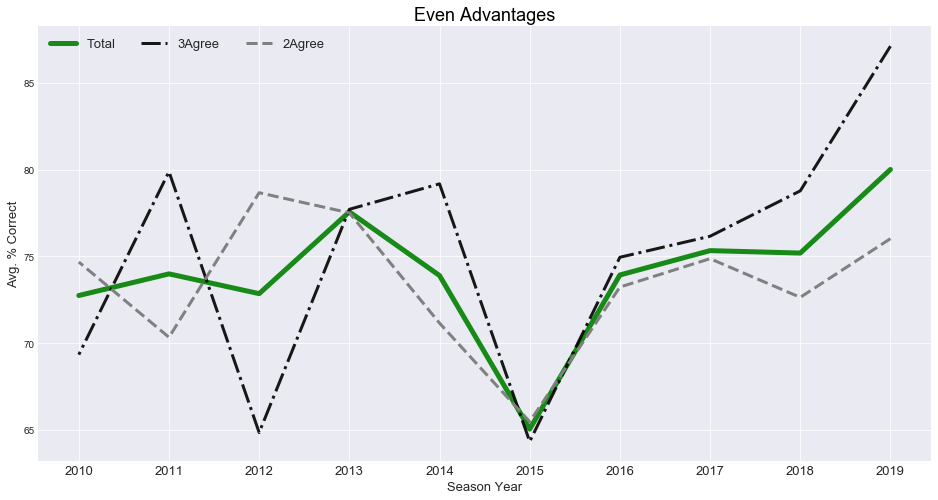

In [432]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(even_totacc_df['Season'], even_totacc_df['Total_Accuracy'], marker='', color='green', linewidth=5, alpha=0.9, label='Total')
plt.plot(even_totacc_df['Season'], even_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='3Agree')
plt.plot(even_totacc_df['Season'], even_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(even_totacc_df['Season'], fontsize=13)
 
# Add titles
plt.title("Even Advantages", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/even_adv_linechart.png')

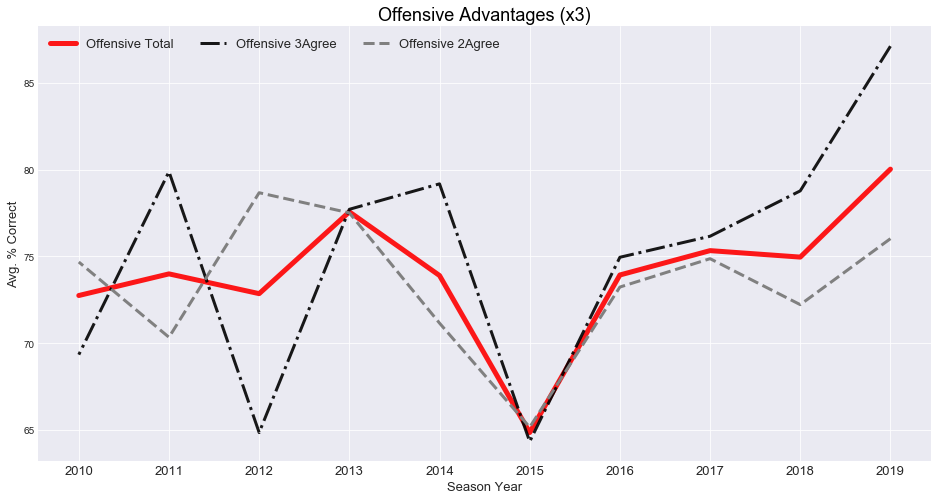

In [433]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(off_totacc_df['Season'], off_totacc_df['Total_Accuracy'], marker='', color='red', linewidth=5, alpha=0.9, label='Offensive Total')
plt.plot(off_totacc_df['Season'], off_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='Offensive 3Agree')
plt.plot(off_totacc_df['Season'], off_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='Offensive 2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(off_totacc_df['Season'], fontsize=13)
 
# Add titles
plt.title("Offensive Advantages (x3)", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/off_adv_linechart.png')

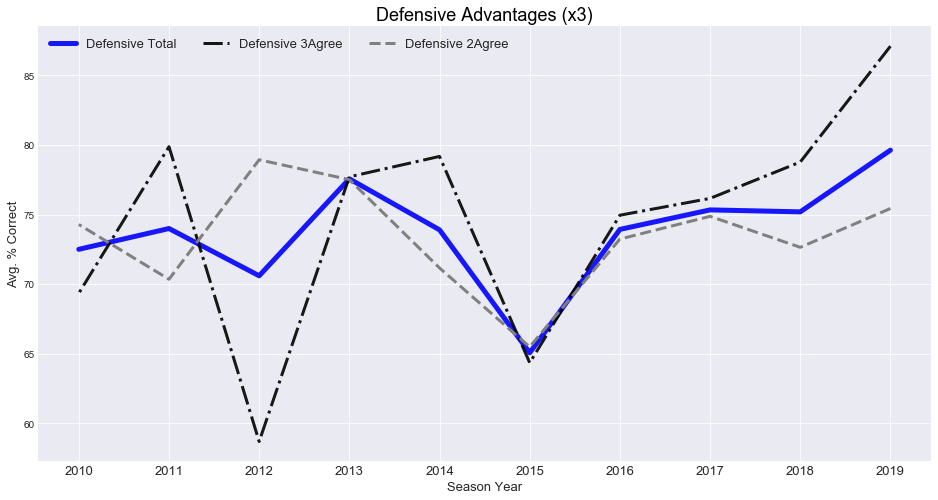

In [434]:
# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,8))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(def_totacc_df['Season'], def_totacc_df['Total_Accuracy'], marker='', color='blue', linewidth=5, alpha=0.9, label='Defensive Total')
plt.plot(def_totacc_df['Season'], def_totacc_df['3Agree_Accuracy'], linestyle='dashdot', marker='', color='black', linewidth=3, alpha=0.9, label='Defensive 3Agree')
plt.plot(def_totacc_df['Season'], def_totacc_df['2Agree_Accuracy'], linestyle='dashed', marker='', color='gray', linewidth=3, alpha=1, label='Defensive 2Agree')

# Add legend
plt.legend(loc=2, ncol=3, fontsize=13)
plt.xticks(def_totacc_df['Season'], fontsize=13)
 
# Add titles
plt.title("Defensive Advantages (x3)", loc='center', fontsize=18, fontweight=0, color='black')
plt.xlabel("Season Year", fontsize=13)
plt.ylabel("Avg. % Correct", fontsize=13)

# Save
plt.savefig('Resources/accuracy_data/figures/def_adv_linechart.png')

In [438]:
predictions_def(weekly_df=week4, year=2020)

---------------
49ers vs. Eagles
Model Prediction: Eagles.
--
Based on Week: 50.0% chance the Eagles win.
Based on Past: 60.0% chance the Eagles win.
Based on Advs: 65.0% chance the Eagles win.
---------------
Rams vs. Giants
Model Prediction: Giants.
--
Based on Week: 60.6% chance the Rams win.
Based on Past: 60.0% chance the Giants win.
Based on Advs: 61.8% chance the Giants win.
---------------
Packers vs. Falcons
Model Prediction: Packers.
--
Based on Week: 66.2% chance the Packers win.
Based on Past: 62.5% chance the Packers win.
Based on Advs: 60.6% chance the Packers win.
---------------
Bears vs. Colts
Model Prediction: Bears.
--
Based on Week: 57.7% chance the Bears win.
Based on Past: 66.7% chance the Colts win.
Based on Advs: 80.9% chance the Bears win.
---------------
Panthers vs. Cardinals
Model Prediction: Panthers.
--
Based on Week: 52.6% chance the Panthers win.
Based on Past: 66.7% chance the Panthers win.
Based on Advs: 57.8% chance the Panthers win.
---------------
B

In [439]:
predictions_even(weekly_df=week4, year=2020)

---------------
49ers vs. Eagles
Model Prediction: Eagles.
--
Based on Week: 50.0% chance the Eagles win.
Based on Past: 60.0% chance the Eagles win.
Based on Advs: 65.0% chance the Eagles win.
---------------
Rams vs. Giants
Model Prediction: Giants.
--
Based on Week: 60.6% chance the Rams win.
Based on Past: 60.0% chance the Giants win.
Based on Advs: 61.8% chance the Giants win.
---------------
Packers vs. Falcons
Model Prediction: Packers.
--
Based on Week: 66.2% chance the Packers win.
Based on Past: 62.5% chance the Packers win.
Based on Advs: 60.6% chance the Packers win.
---------------
Bears vs. Colts
Model Prediction: Bears.
--
Based on Week: 57.7% chance the Bears win.
Based on Past: 66.7% chance the Colts win.
Based on Advs: 80.9% chance the Bears win.
---------------
Panthers vs. Cardinals
Model Prediction: Panthers.
--
Based on Week: 52.6% chance the Panthers win.
Based on Past: 66.7% chance the Panthers win.
Based on Advs: 57.8% chance the Panthers win.
---------------
B

In [440]:
predictions_off(weekly_df=week4, year=2020)

---------------
49ers vs. Eagles
Model Prediction: Eagles.
--
Based on Week: 50.0% chance the Eagles win.
Based on Past: 60.0% chance the Eagles win.
Based on Advs: 65.0% chance the Eagles win.
---------------
Rams vs. Giants
Model Prediction: Giants.
--
Based on Week: 60.6% chance the Rams win.
Based on Past: 60.0% chance the Giants win.
Based on Advs: 61.8% chance the Giants win.
---------------
Packers vs. Falcons
Model Prediction: Packers.
--
Based on Week: 66.2% chance the Packers win.
Based on Past: 62.5% chance the Packers win.
Based on Advs: 60.6% chance the Packers win.
---------------
Bears vs. Colts
Model Prediction: Bears.
--
Based on Week: 57.7% chance the Bears win.
Based on Past: 66.7% chance the Colts win.
Based on Advs: 80.9% chance the Bears win.
---------------
Panthers vs. Cardinals
Model Prediction: Panthers.
--
Based on Week: 52.6% chance the Panthers win.
Based on Past: 66.7% chance the Panthers win.
Based on Advs: 57.8% chance the Panthers win.
---------------
B

,Unnamed: 0,Year,Week,Day,Base_Team,Opp,Home,After_Bye,Wins Tally,PF Tally,...,TO_lost Tally,DPassY Tally,DRushY Tally,DTotYd Tally,TO_won Tally,Head_Coach,OC,DC,QB,Results
4,4,2020,5,Sun,49ers,Dolphins,1.0,0,NaN,107.0,...,4.0,736.0,443.0,1179.0,5.0,Kyle Shanahan,Kyle Shanahan,Robert Saleh,Jimmy Garoppolo,NaN
180,180,2020,5,Sun,Rams,Washington,0.0,0,NaN,106.0,...,5.0,919.0,494.0,1413.0,6.0,Sean McVay,Kevin O'Connell,Brandon Staley,Jared Goff,NaN
356,356,2020,5,Mon,Chargers,Saints,0.0,0,NaN,83.0,...,7.0,1052.0,443.0,1495.0,3.0,Anthony Lynn,Shane Steichen,Gus Bradley,Tyrod Taylor,NaN
532,532,2020,5,Sun,Seahawks,Vikings,1.0,0,NaN,142.0,...,3.0,1604.0,303.0,1907.0,8.0,Pete Carroll,Brian Schottenheimer,Ken Norton,Russell Wilson,NaN
708,708,2020,5,Sun,Cardinals,Jets,0.0,0,NaN,98.0,...,6.0,950.0,498.0,1448.0,3.0,Kliff Kingsbury,Kliff Kingsbury,Vance Joseph,Kyler Murray,NaN
1060,1060,2020,5,Mon,Saints,Chargers,1.0,0,NaN,123.0,...,3.0,947.0,390.0,1337.0,5.0,Sean Payton,Pete Carmichael,Dennis Allen,Drew Brees,NaN
1236,1236,2020,5,Sun,Giants,Cowboys,0.0,0,NaN,47.0,...,8.0,886.0,427.0,1313.0,4.0,Joe Judge,Jason Garrett,Patrick Graham,Daniel Jones,NaN
1412,1412,2020,5,Thu,Bears,Buccaneers,1.0,0,NaN,85.0,...,5.0,921.0,460.0,1381.0,4.0,Matt Nagy,Bill Lazor,Chuck Pagano,Mitchell Trubisky,NaN
1588,1588,2020,5,Sun,Panthers,Falcons,0.0,0,NaN,99.0,...,5.0,908.0,501.0,1409.0,7.0,Matt Rhule,Joe Brady,Phil Snow,Teddy Bridgewater,NaN
1764,1764,2020,5,Thu,Buccaneers,Bears,0.0,0,NaN,120.0,...,6.0,991.0,257.0,1248.0,8.0,Bruce Arians,Byron Leftwich,Todd Bowles,Tom Brady,NaN
